### Analyzing the impact of different features on movie revenue.

Goals:
    1. To determine which movie genres generate higher gross.
    2. To find out whether a higher rating affects worldwide revenue.
    3. To determine whether runtime has an impact on worldwide revenue.
    4. To find out whether high movie rating yields a higher revenue.
    5. To determine whether the month a movie is released affects revenue.

In [1]:
# Importing libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import sqlite3
from pandasql import sqldf

In [2]:
# SQLite connection.
conn=sqlite3.connect('../datasets/im.db')
query='''
SELECT *
    FROM sqlite_master;
'''
pd.read_sql(query,conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [3]:
# Merging datasets.
query2='''
SELECT *
    FROM movie_basics
    JOIN movie_ratings
    USING(movie_id);
'''
movie_basics_and_ratings=pd.read_sql(query2,conn)
movie_basics_and_ratings.dropna(inplace=True)
movie_basics_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   primary_title    65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [4]:
# Loading the movie budgets data.
movie_budgets = pd.read_csv('../datasets/tn.movie_budgets.csv', index_col=0)
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


In [5]:
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.production_budget = movie_budgets.production_budget.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.domestic_gross = movie_budgets.domestic_gross.str.replace('[\$,]', '', regex=True).astype('int64')
movie_budgets.release_date = pd.to_datetime(movie_budgets.release_date)
print(movie_budgets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 271.0+ KB
None


In [6]:
# Merging datasets.
pysqldf=lambda q: sqldf(q,globals())
query3='''
SELECT *
    FROM movie_basics_and_ratings AS mbr
    JOIN movie_budgets
    ON mbr.primary_title=movie_budgets.movie;
'''
movie_details_and_revenue=pysqldf(query3)
movie_details_and_revenue.release_date = pd.to_datetime(movie_details_and_revenue.release_date)
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
dtypes: datet

In [7]:
# Top 10 genres ordered by domestic and worldwide gross.
top_10_genres=movie_details_and_revenue.groupby('genres')[['production_budget','domestic_gross','worldwide_gross']].mean().sort_values(by=['domestic_gross','worldwide_gross'],ascending=False).head(10)
top_10_genres

,production_budget,domestic_gross,worldwide_gross
genres,,,
"Family,Fantasy,Musical",9.000000e+07,4.400357e+08,9.338154e+08
"Adventure,Drama,Sport",1.500000e+08,4.007380e+08,1.272470e+09
"Fantasy,Romance",1.500000e+08,4.007380e+08,1.272470e+09
"Action,Adventure,Sci-Fi",1.606103e+08,2.203234e+08,5.991302e+08
"Adventure,Fantasy",2.316667e+08,1.928914e+08,7.012107e+08
"Comedy,Romance,Sci-Fi",6.500000e+07,1.828051e+08,3.741051e+08
"Biography,Documentary,History",9.025000e+07,1.810211e+08,4.299082e+08
"Biography,Drama,Musical",8.400000e+07,1.743402e+08,3.866656e+08
"Adventure,Drama,Western",3.500000e+07,1.712430e+08,2.522769e+08


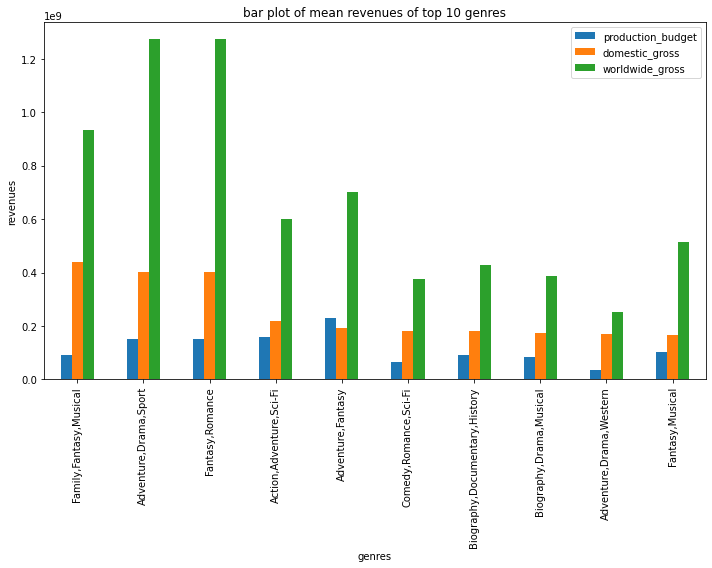

In [8]:
# Plot for the top 10 genres.
top_10_genres.plot(kind='bar',figsize=(10,8))
plt.title('bar plot of mean revenues of top 10 genres')
plt.ylabel('revenues')
plt.tight_layout();

A mix of adventure, Drama, Sport and also a mix of Fantasy, Romance seem to yield high profit domestically and worldwide.

### Do high budget films result in high revenue?

In [9]:
# Probability of Superiority.
print(sum(x>y for x,y in zip(movie_details_and_revenue.worldwide_gross,movie_details_and_revenue.production_budget))/len(movie_details_and_revenue))
print(sum(x>y for x,y in zip(movie_details_and_revenue.domestic_gross,movie_details_and_revenue.production_budget))/len(movie_details_and_revenue))

0.6133720930232558
0.4069767441860465


##### This shows that there is a 61% chance that a movie of any genre can get a worldwide revenue greater than its production budget.
##### This shows that there is a 41% chance that a movie of any genre can get a domestic revenue greater than its production budget.

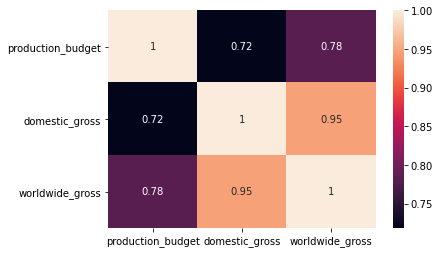

In [10]:
# correlation heatmap.
sns.heatmap(movie_details_and_revenue[['production_budget','domestic_gross','worldwide_gross']].corr(),annot=True);

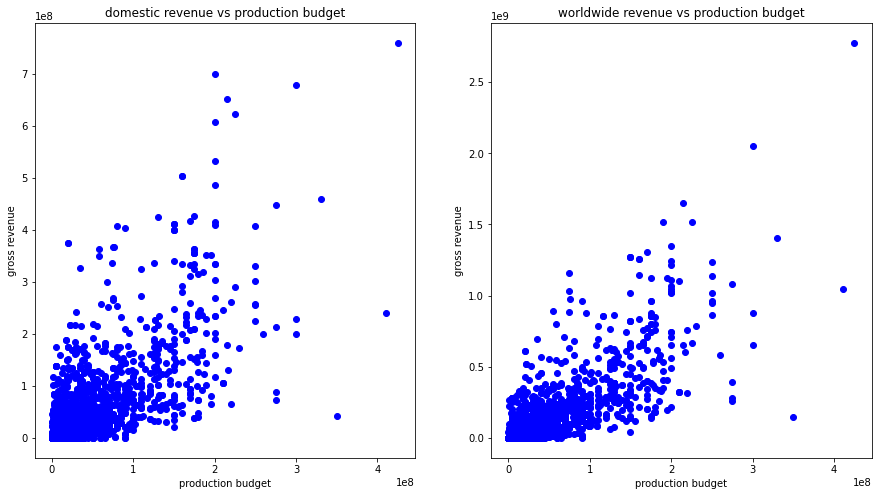

In [11]:
#Scatter plots
fig, ax = plt.subplots(ncols=2,figsize=(15,8))
ax[0].scatter(movie_details_and_revenue.production_budget,movie_details_and_revenue.domestic_gross, color='blue')
ax[1].scatter(movie_details_and_revenue.production_budget,movie_details_and_revenue.worldwide_gross, color='blue')
ax[0].set_title('domestic revenue vs production budget')
ax[1].set_title('worldwide revenue vs production budget')
for a in ax:
    a.set_xlabel('production budget')
    a.set_ylabel('gross revenue');

#### This shows that there seems to be a positive linear relationship between production budget and the revenue. The higher the budget the higher the revenue.

#### Is there a relationship between movie rating and revenue?

H<sub>0</sub>: The mean worldwide revenue for high rated movies is less than or equal to that of low rated movies vs
H<sub>1</sub>: The mean worldwide revenue for high rated movies is greater than that of low rated movies at 5% level of significance.

In [12]:
movie_details_and_revenue.groupby('averagerating')[['domestic_gross','worldwide_gross']].mean().sort_values(by=['domestic_gross','worldwide_gross'],ascending=False).head(10)

,domestic_gross,worldwide_gross
averagerating,,
8.5,1.055267e+08,3.311156e+08
7.8,1.011214e+08,2.535872e+08
8.0,9.187968e+07,2.614439e+08
8.1,9.158098e+07,2.129984e+08
8.3,8.998933e+07,2.566749e+08
7.5,7.899036e+07,1.931210e+08
2.3,7.554777e+07,1.755373e+08
2.6,7.387569e+07,2.060384e+08
1.6,7.301391e+07,9.903412e+07


In [13]:
high_rated=movie_details_and_revenue[movie_details_and_revenue['averagerating']>=7.0]['worldwide_gross']
low_rated=movie_details_and_revenue[movie_details_and_revenue['averagerating']<7.0]['worldwide_gross']
t_stat, p = stats.ttest_ind(high_rated,low_rated,equal_var=False)
if t_stat>0:
    p_value_one_sided=p/2
else:
    p_value_one_sided=1-(p/2)
p_value_one_sided

2.0475399338393774e-13

##### Our p-value=2.0475399338393774e-13 is less than our threshold and thus we reject the null hypothesis and conclude that we have sufficient statistical evidence to claim that the mean worldwide revenue for high rated movies is higher than the mean worldwide revenue of low rated movies at 5% level of significance.

##### Is there a relationship between runtime and revenue?

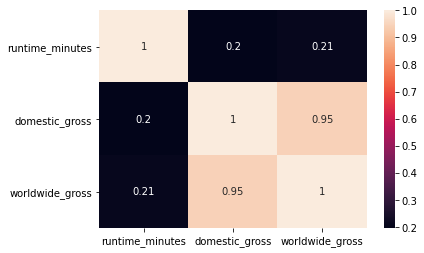

In [14]:
sns.heatmap(movie_details_and_revenue[['runtime_minutes','domestic_gross','worldwide_gross']].corr(), annot=True);

There seems to be a very weak positive relationship between runtime in minutes and revenue.

**Does the month of the year affect revenue?**

In [15]:
query4='''
SELECT strftime("%m", release_date) AS month, AVG(worldwide_gross) AS 'average worldwide gross'
    FROM movie_details_and_revenue
    GROUP BY month;
'''
monthly_average_revenue=pysqldf(query4)
monthly_average_revenue

,month,average worldwide gross
0,01,6.833946e+07
1,02,8.925310e+07
2,03,1.259204e+08
3,04,8.945937e+07
4,05,1.579685e+08
5,06,1.733710e+08
6,07,1.394714e+08
7,08,6.419810e+07
8,09,5.323615e+07
9,10,6.253563e+07


In [16]:
month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
movie_details_and_revenue['month_released']=movie_details_and_revenue.release_date.dt.month.map(month_map)
movie_details_and_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   int64         
 13  worldwide_gross    2752 non-null   int64         
 14  month_re

*H<sub>0</sub>: month does not have a significant effect on worldwide gross VS
H<sub>1</sub>: month has a significant effect on worldwide gross at 5% level of significance.*

In [17]:
# Grouping worldwide gross by month.
groups = [
    movie_details_and_revenue.loc[movie_details_and_revenue['month_released'] == m, 'worldwide_gross'] for m in sorted(movie_details_and_revenue['month_released'].unique())
]
f_stat, p = f_oneway(*groups)
p

5.8301897405767244e-18

**Since our p value = 5.8301897405767244e-18 is less than our threshold we reject the null and conclude that the month has a significant impact on worldwide gross at 5% level of significance.**